## Purpose
The purpose of this application is to solve relevant classification and regression problems for the prostate dataset for use in the project in 02450 Intro to Machine Learning

Author: Naia Wright

Reviewed by:  

Last modified: 28/10/18, 09:39

#### Change-log


Import of required packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from scipy.linalg import svd

from scipy.io import loadmat
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sklearn.linear_model as lm
from matplotlib.pylab import figure, plot, xlabel, ylabel, legend, ylim, show

from matplotlib.pyplot import figure, boxplot, xlabel, ylabel, show
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection, tree
from scipy import stats

from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection

from matplotlib.pyplot import figure, plot, subplot, title, xlabel, ylabel, show, clim
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from toolbox_02450 import feature_selector_lr, bmplot
import numpy as np

from statistics import mean
import graphviz
from numpy import array
from scipy import stats

#### Import of data

First we define a method for importing a spread_sheet using pandas

In [3]:
def DataLoader(path, sheet):
    """
    Method for importing data from a spreadsheet.

    :param path: full path to the spreadsheet to load
    :param sheet: name of the sheet in the workbook that is loaded
    :return: pandas dataFrame with imported data
    """
    import pandas as pd

    out = pd.read_excel(path, sheet_name=sheet)

    return out

In [4]:
# Specify path and sheet name in the prostate workbook
#filePath = 'C:/Users/PeterBakke/Documents/git/ML_fall2018/Data/Prostate.xlsx'
#filePath = 'C:/Users/Greta/Documents/Github/ML_fall2018/Data/Prostate.xlsx'
filePath = 'C:/Users/narisa/Documents/GitHub/ML_fall2018/Data/Prostate.xlsx'
sheet = 'Sheet1'

In [5]:
# load prostate data into dataFrame
myData = DataLoader(path=filePath, sheet=sheet)

# delete irrelevant columns
del myData['ID']
del myData['train']

In [6]:
# extract class names and encode with integers (dict)

classLabels = myData['Gleason'].values.tolist()
classNames = sorted(set(classLabels))
classDict = dict(zip(classNames, range(4)))

#del myData['Gleason']

attributeNames = list(myData.columns.values)

print(attributeNames)
print(classDict)

['lCaVol', 'lWeight', 'Age', 'lBPH', 'SVI', 'lCP', 'Gleason', 'pgg45', 'lPSA']
{6: 0, 7: 1, 8: 2, 9: 3}


In [7]:
# Extract vector y, convert to NumPy array
y = np.asarray([classDict[value] for value in classLabels])

# Convert dataFrame to numpy array
X = myData.values

# Compute values of N, M and C
N = len(y)
M = len(attributeNames)
C = len(classNames)

In [8]:
# Normalize data with mean and std
Y = (X - np.ones((N,1))*X.mean(axis=0)) / X.std(axis=0)
print(X)

[[-5.79818495e-01  2.76945900e+00  5.00000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  6.00000000e+00  0.00000000e+00
  -4.30782900e-01]
 [-9.94252273e-01  3.31962600e+00  5.80000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  6.00000000e+00  0.00000000e+00
  -1.62518900e-01]
 [-5.10825624e-01  2.69124300e+00  7.40000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  7.00000000e+00  2.00000000e+01
  -1.62518900e-01]
 [-1.20397280e+00  3.28278900e+00  5.80000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  6.00000000e+00  0.00000000e+00
  -1.62518900e-01]
 [ 7.51416089e-01  3.43237300e+00  6.20000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  6.00000000e+00  0.00000000e+00
   3.71563600e-01]
 [-1.04982212e+00  3.22882600e+00  5.00000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  6.00000000e+00  0.00000000e+00
   7.65467800e-01]
 [ 7.37164066e-01  3.47351800e+00  6.40000000e+01  6.15185640e-01
   0.00000000e+00 -1.3862943

## Classification

In [9]:
# Remove attribute 5 (SVI) from X
X_classification = X[:,[0,1,2,3,5,6,7,8]]
print(X)
# Use attribute 5 (SVI) as y
y_classification = X[:,4]
# Remove attribute 5 (SVI) from attribute names

attributeNames_classification = np.array(attributeNames)[[0, 1, 2, 3, 5, 6, 7, 8]]
print(attributeNames_classification)


[[-5.79818495e-01  2.76945900e+00  5.00000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  6.00000000e+00  0.00000000e+00
  -4.30782900e-01]
 [-9.94252273e-01  3.31962600e+00  5.80000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  6.00000000e+00  0.00000000e+00
  -1.62518900e-01]
 [-5.10825624e-01  2.69124300e+00  7.40000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  7.00000000e+00  2.00000000e+01
  -1.62518900e-01]
 [-1.20397280e+00  3.28278900e+00  5.80000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  6.00000000e+00  0.00000000e+00
  -1.62518900e-01]
 [ 7.51416089e-01  3.43237300e+00  6.20000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  6.00000000e+00  0.00000000e+00
   3.71563600e-01]
 [-1.04982212e+00  3.22882600e+00  5.00000000e+01 -1.38629436e+00
   0.00000000e+00 -1.38629436e+00  6.00000000e+00  0.00000000e+00
   7.65467800e-01]
 [ 7.37164066e-01  3.47351800e+00  6.40000000e+01  6.15185640e-01
   0.00000000e+00 -1.3862943

# Q2

## Two level cross validation for KNN - Naia 2018-11-03 

In [10]:
## Crossvalidation for KNN
## The selection of optimal model is based on an average of the inner errors for each model

# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True)
#CV = model_selection.StratifiedKFold(n_splits=K)
index_min_lst = []
min_indices = []
error_outer = [] # List for the errors in outer CV fold
dict_inner = {}
error_inner = {} # Dict with the errors in the innter CV fold for each tested model
K_KNN = range(1,41) # Change here for different nearest neighbour crossvalidation - test of K=1-40

for count, value in enumerate(K_KNN):
    error_inner['K_KNN_of_{0}'.format(value)] = []

k=0
classifier_lst = []

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
        for count, value in enumerate(K_KNN):
            dist=1
                       
            knclassifier = KNeighborsClassifier(n_neighbors=value, p=dist);
            knclassifier.fit(X_train_inner, y_train_inner);
            classifier_lst.append(knclassifier)
            
            y_KNN = knclassifier.predict(X_test_inner);
            errorKNN_inner = 100*(y_KNN!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            #index_min_lst.append(errorKNN_inner) #Append the error values to a list
            error_inner['K_KNN_of_{0}'.format(value)].append(errorKNN_inner) # add errors for each fold to each model
            
        kk += 1
        
    # Find the KNN value with minimum average error value
    for key in error_inner.keys():
        index_min_lst.append(mean(error_inner[key]))
        
    print('Inner_error_values are:' + str(index_min_lst))
    index_min = np.argmin(index_min_lst) #Find the index of the minimum error value
    top_count = index_min
    min_indices.append(index_min) 
        
    index_min_lst = [] # Clear for next CV fold
    
    for key in error_inner.keys():
        error_inner[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal KNN value is: ' + str(top_count))
    
    optimal_K = K_KNN[top_count]
    
    print('The optimal KNN value across inner CV folds is: ' + str(optimal_K))
    
    knclassifierOuter = KNeighborsClassifier(n_neighbors=optimal_K, p=dist); #Uses optimal_K, which was found in the inner CV loop
    knclassifierOuter.fit(X_train_outer, y_train_outer);
            
    y_KNN_outer = knclassifierOuter.predict(X_test_outer);
    errorKNN_outer = 100*(y_KNN_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer.append(errorKNN_outer)
    print('Errors for each outer CV fold: ' + str(error_outer))
error_KNN = error_outer

CV-fold 1 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
Inner_error_values are:[26.166666666666668, 18.25, 26.333333333333336, 25.0, 22.416666666666668, 23.583333333333332, 26.166666666666668, 27.5, 26.25, 25.0, 27.5, 26.166666666666668, 26.166666666666668, 23.5, 26.166666666666668, 22.166666666666668, 22.166666666666668, 19.583333333333336, 18.25, 18.25, 18.25, 18.25, 18.25, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336, 19.583333333333336]
The index of optimal KNN value is: 1
The optimal KNN value across inner CV folds is: 2
Errors for each outer CV fold: [25.0]
CV-fold 2 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 

## Two level cross validation for decision trees

In [11]:
## Crossvalidation for decision trees
## The selection of optimal model is based on an average of the inner errors for each model

# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True)
#CV = model_selection.StratifiedKFold(n_splits=K)
index_min_lst = []
min_indices = []
error_outer = [] # List for the errors in outer CV fold
dict_inner = {}
error_inner = {} # Dict with the errors in the innter CV fold for each tested model
# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)
print(tc)


for count, value in enumerate(tc):
    error_inner['tc_of_{0}'.format(value)] = []

k=0
classifier_lst = []

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
        for count, value in enumerate(tc):
            dist=1
            
            # Fit decision tree classifier, Gini split criterion, different pruning levels
            dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=value) 
            dtc.fit(X_train_inner, y_train_inner.ravel());
            classifier_lst.append(dtc)
            
            y_dtc = dtc.predict(X_test_inner);
            errordtc_inner = 100*(y_dtc!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            #index_min_lst.append(errorKNN_inner) #Append the error values to a list
            error_inner['tc_of_{0}'.format(value)].append(errordtc_inner) # add errors for each fold to each model
            
        kk += 1
        
    # Find the KNN value with minimum average error value
    for key in error_inner.keys():
        index_min_lst.append(mean(error_inner[key]))
        
    print('Inner_error_values are:' + str(index_min_lst))
    index_min = np.argmin(index_min_lst) #Find the index of the minimum error value
    top_count = index_min
    min_indices.append(index_min) 
        
    index_min_lst = [] # Clear for next CV fold
    
    for key in error_inner.keys():
        error_inner[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal tc value is: ' + str(top_count))
    
    optimal_tc = tc[top_count]
    
    print('The optimal tc value across inner CV folds is: ' + str(optimal_tc))
    
    
    dtcclassifierOuter = tree.DecisionTreeClassifier(criterion='gini', max_depth=optimal_tc);  #Uses optimal_tc, which was found in the inner CV loop
    dtcclassifierOuter.fit(X_train_outer, y_train_outer.ravel());
            
    y_dtc_outer = dtcclassifierOuter.predict(X_test_outer);
    errordtc_outer = 100*(y_dtc_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer.append(errordtc_outer)
    print('Errors for each outer tc fold: ' + str(error_outer))

error_dct = error_outer

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
CV-fold 1 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
Inner_error_values are:[16.916666666666668, 14.166666666666666, 16.916666666666668, 19.583333333333336, 14.25, 15.5, 14.25, 19.583333333333332, 16.916666666666668, 16.916666666666668, 15.5, 15.5, 18.25, 12.916666666666668, 19.583333333333332, 19.416666666666668, 16.833333333333332, 22.166666666666668, 12.916666666666668]
The index of optimal tc value is: 13
The optimal tc value across inner CV folds is: 15
Errors for each outer tc fold: [5.0]
CV-fold 2 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
Inner_error_values are:[24.75, 23.333333333333332, 24.75, 29.833333333333332, 27.333333333333332, 27.333333333333332, 24.833333333333332, 27.333333333333332, 26.0, 24.666666666666668, 25.916666666666668, 26.0, 26.0, 24.666666666666668, 27.25, 26.08333333

## Two level cross validation for Naive Bayes

In [12]:
### OBS. method can not use X values < 0

## Crossvalidation for Naive Bayes
## The selection of optimal model is based on an average of the inner errors for each model

# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True)
#CV = model_selection.StratifiedKFold(n_splits=K)
index_min_lst = []
min_indices = []
error_outer = np.empty((1,1)) # List for the errors in outer CV fold
dict_inner = {}
error_inner = {} # Dict with the errors in the innter CV fold for each tested model

# Naive Bayes classifier parameters
alpha = [1]         # additive parameter (e.g. Laplace correction), lægges til da log bliver taget i MultinormilNB

for count, value in enumerate(K_KNN):
    error_inner['K_KNN_of_{0}'.format(value)] = []

k=0
classifier_lst = []

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        print(X_train_inner) 
        for count, value in enumerate(alpha):
            est_prior = True  # uniform prior (change to True to estimate prior from data)    
                       
            nbclassifier = MultinomialNB(alpha=alpha, fit_prior=est_prior);
            nbclassifier.fit(X_train_inner, y_train_inner);
            classifier_lst.append(nbclassifier)
 
            y_NB = nbclassifier.predict(X_test_inner);
            errorNB_inner = 100*(y_NB!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            #index_min_lst.append(errorKNN_inner) #Append the error values to a list
            error_inner['alpha_of_{0}'.format(value)].append(errorNB_inner) # add errors for each fold to each model
            
        kk += 1
        
    # Find the alpha value with minimum average error value
    for key in error_inner.keys():
        index_min_lst.append(mean(error_inner[key]))
        
    print('Inner_error_values are:' + str(index_min_lst))
    index_min = np.argmin(index_min_lst) #Find the index of the minimum error value
    top_count = index_min
    min_indices.append(index_min) 
        
    index_min_lst = [] # Clear for next CV fold
    
    for key in error_inner.keys():
        error_inner[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal KNN value is: ' + str(top_count))
    
    optimal_alpha = alpha[top_count]
    
    print('The optimal KNN value across inner CV folds is: ' + str(optimal_K))
    
    nbclassifierOuter = MultinomialNB(alpha=optimal_alpha, fit_prior=est_prior); #Uses optimal_alpha, which was found in the inner CV loop
    nbclassifierOuter.fit(X_train_outer, y_train_outer);
            
    y_NB_outer = nbclassifier.predict(X_test_outer);
    errorNB_outer = 100*(y_NB_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer.append(errorNB_outer)
    print('Errors for each outer CV fold: ' + str(error_outer))


CV-fold 1 of 5
Inner CV-fold 1 of 5
[[-9.94252273e-01  3.31962600e+00  5.80000000e+01 -1.38629436e+00
  -1.38629436e+00  6.00000000e+00  0.00000000e+00 -1.62518900e-01]
 [-5.10825624e-01  2.69124300e+00  7.40000000e+01 -1.38629436e+00
  -1.38629436e+00  7.00000000e+00  2.00000000e+01 -1.62518900e-01]
 [-1.20397280e+00  3.28278900e+00  5.80000000e+01 -1.38629436e+00
  -1.38629436e+00  6.00000000e+00  0.00000000e+00 -1.62518900e-01]
 [ 7.51416089e-01  3.43237300e+00  6.20000000e+01 -1.38629436e+00
  -1.38629436e+00  6.00000000e+00  0.00000000e+00  3.71563600e-01]
 [-1.04982212e+00  3.22882600e+00  5.00000000e+01 -1.38629436e+00
  -1.38629436e+00  6.00000000e+00  0.00000000e+00  7.65467800e-01]
 [ 7.37164066e-01  3.47351800e+00  6.40000000e+01  6.15185640e-01
  -1.38629436e+00  6.00000000e+00  0.00000000e+00  7.65467800e-01]
 [ 2.23143551e-01  3.24454400e+00  6.30000000e+01 -1.38629436e+00
  -1.38629436e+00  6.00000000e+00  0.00000000e+00  1.04731900e+00]
 [ 2.54642218e-01  3.60413800e+00

ValueError: Input X must be non-negative

Text(0,0.5,'Cross-validation error [%]')

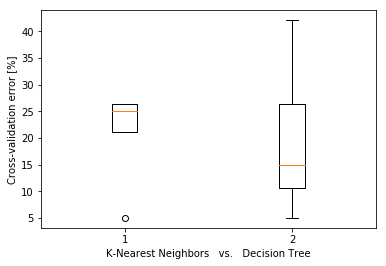

In [13]:
figure()
boxplot([error_KNN, error_dct])
xlabel('K-Nearest Neighbors   vs.   Decision Tree')
ylabel('Cross-validation error [%]')

# Q3

In [15]:
# Method selected: Decision Trees

In [16]:
# Re-estimate of the model on all data for a maximum depth of 12 

# Fit decision tree classifier, Gini split criterion, maximum depth of 12 on all data
dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=12) 
dtc.fit(X_classification, y_classification.ravel())

# New data object
#new_data = np.array([-5, 2, 4, -1, -1, 5, 0, -3]).reshape(1,-1) # Gives 0 - No SVI
new_data = np.array([3, 2, 4, -1, 2, 5, 0, -3]).reshape(1,-1) # Gives 1 - Yes SVI

# Evalulate the decision tree for a new data object
new_data_class = dtc.predict(new_data)[0]
print(new_data_class)

1.0


In [17]:
print(attributeNames_classification)

['lCaVol' 'lWeight' 'Age' 'lBPH' 'lCP' 'Gleason' 'pgg45' 'lPSA']


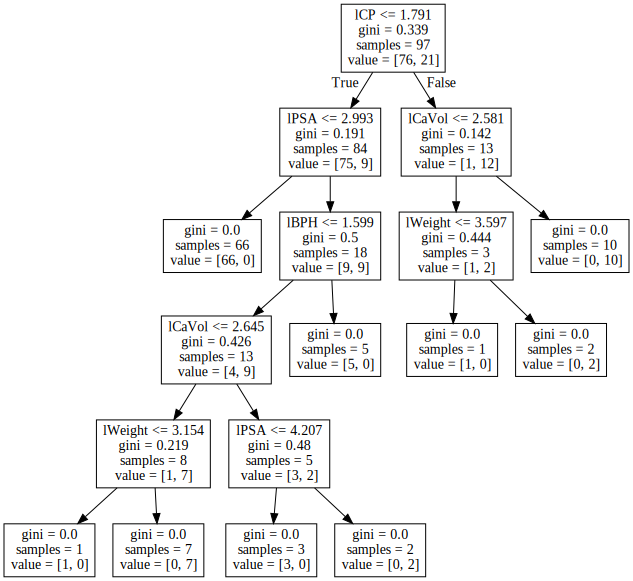

In [18]:
# Export tree graph for visualization purposes:
# (note: you can use i.e. Graphviz application to visualize the file)
out = tree.export_graphviz(dtc, out_file='tree_gini.gvz', feature_names=attributeNames_classification)
#graphviz.render('dot','png','tree_gini',quiet=False)
src=graphviz.Source.from_file('tree_gini.gvz')
## Comment in to automatically open pdf
## Note. If you get an error (e.g. exit status 1), try closing the pdf file/viewer
#src.render('../tree_gini', view=True)
src

# Q4

### Baseline model

In [19]:
# Baseline model
# zero rule algorithm for classification
def Baseline_model(y_train, y_test):
    prediction = stats.mode(y_train)[0]
    predicted = [int(prediction) for i in range(len(y_test))]
    return predicted

### Two-level-cross validation for dtc, KNN and baseline model

In [44]:
# Results from the 2-level cross-validation for dtc 
# Errors for each outer tc fold: [15.0, 30.0, 10.526315789473685, 10.526315789473685, 15.789473684210526]
# The errors for the best performing models are: 10.526315789473685, 15.0
## Crossvalidation for decision trees
## The selection of optimal model is based on an average of the inner errors for each model

# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True)
#CV = model_selection.StratifiedKFold(n_splits=K)

# dtc
index_min_lst_dtc = []
min_indices_dtc = []
error_outer_dtc = [] # List for the errors in outer CV fold
dict_inner_dtc = {}
error_inner_dtc = {} # Dict with the errors in the innter CV fold for each tested model
# Tree complexity parameter - constraint on maximum depth
tc = np.arange(2, 21, 1)
classifier_lst_dtc = []

for count, value in enumerate(tc):
    error_inner_dtc['tc_of_{0}'.format(value)] = []

# KNN
index_min_lst_KNN = []
min_indices_KNN = []
error_outer_KNN = [] # List for the errors in outer CV fold
dict_inner_KNN = {}
error_inner_KNN = {} # Dict with the errors in the innter CV fold for each tested model
K_KNN = range(1,41) # Change here for different nearest neighbour crossvalidation - test of K=1-40
classifier_lst_KNN = []

for count, value in enumerate(K_KNN):
    error_inner_KNN['K_KNN_of_{0}'.format(value)] = []
    
# Baseline model
error_baseline = []



k=0

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
    # Decision tree classifier
        for count, value in enumerate(tc):
            dist=1
            
            # Fit decision tree classifier, Gini split criterion, different pruning levels
            dtc = tree.DecisionTreeClassifier(criterion='gini', max_depth=value) 
            dtc.fit(X_train_inner, y_train_inner.ravel());
            classifier_lst_dtc.append(dtc)
            
            y_dtc = dtc.predict(X_test_inner);
            errordtc_inner = 100*(y_dtc!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            #index_min_lst.append(errorKNN_inner) #Append the error values to a list
            error_inner_dtc['tc_of_{0}'.format(value)].append(errordtc_inner) # add errors for each fold to each model
    
    # KNN classifier
            for count, value in enumerate(K_KNN):
                dist=1
                       
                knclassifier = KNeighborsClassifier(n_neighbors=value, p=dist);
                knclassifier.fit(X_train_inner, y_train_inner);
                classifier_lst_KNN.append(knclassifier)
            
                y_KNN = knclassifier.predict(X_test_inner);
                errorKNN_inner = 100*(y_KNN!=y_test_inner).sum().astype(float)/len(y_test_inner)  
                #index_min_lst.append(errorKNN_inner) #Append the error values to a list
                error_inner_KNN['K_KNN_of_{0}'.format(value)].append(errorKNN_inner) # add errors for each fold to each model
        
        
        kk += 1
    #dtc
    # Find the dtc value with minimum average error value
    for key in error_inner_dtc.keys():
        index_min_lst_dtc.append(mean(error_inner_dtc[key]))
        
    print('Inner_error_values_ for dtc are:' + str(index_min_lst_dtc))
    index_min_dtc = np.argmin(index_min_lst_dtc) #Find the index of the minimum error value
    top_count_dtc = index_min_dtc
    min_indices_dtc.append(index_min_dtc) 
        
    index_min_lst_dtc = [] # Clear for next CV fold
    
    for key in error_inner_dtc.keys():
        error_inner_dtc[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal tc value is: ' + str(top_count))
    
    optimal_tc = tc[top_count_dtc]
    
    print('The optimal tc value across inner CV folds is: ' + str(optimal_tc))
    
    
    dtcclassifierOuter = tree.DecisionTreeClassifier(criterion='gini', max_depth=optimal_tc);  #Uses optimal_tc, which was found in the inner CV loop
    dtcclassifierOuter.fit(X_train_outer, y_train_outer.ravel());
            
    y_dtc_outer = dtcclassifierOuter.predict(X_test_outer);
    errordtc_outer = 100*(y_dtc_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer_dtc.append(errordtc_outer)
    print('Errors for each outer tc fold: ' + str(error_outer_dtc))
    
    
    # KNN
    # Find the KNN value with minimum average error value
    for key in error_inner_KNN.keys():
        index_min_lst_KNN.append(mean(error_inner_KNN[key]))
        
    print('Inner_error_values are:' + str(index_min_lst_KNN))
    index_min_KNN = np.argmin(index_min_lst_KNN) #Find the index of the minimum error value
    top_count_KNN = index_min_KNN
    min_indices_KNN.append(index_min_KNN) 
        
    index_min_lst_KNN = [] # Clear for next CV fold
    
    for key in error_inner_KNN.keys():
        error_inner_KNN[key] = [] # Clear for next CV fold
        
      
    print('The index of optimal KNN value is: ' + str(top_count))
    
    optimal_K = K_KNN[top_count_KNN]
    
    print('The optimal KNN value across inner CV folds is: ' + str(optimal_K))
    
    knclassifierOuter = KNeighborsClassifier(n_neighbors=optimal_K, p=dist); #Uses optimal_K, which was found in the inner CV loop
    knclassifierOuter.fit(X_train_outer, y_train_outer);
            
    y_KNN_outer = knclassifierOuter.predict(X_test_outer);
    errorKNN_outer = 100*(y_KNN_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer_KNN.append(errorKNN_outer)
    print('Errors for each outer CV fold: ' + str(error_outer_KNN))
 
    
    
    # Fit baseline model
            
    y_baselinemodel = Baseline_model(y_train_outer, y_test_outer);
    error_baseline_outer = 100*(y_baselinemodel!=y_test_outer).sum().astype(float)/len(y_test_outer)  
    error_baseline.append(error_baseline_outer)
    print('Errors for baseline outer fold'+str(error_baseline))

error_dct = error_outer_dtc
error_KNN = error_outer_KNN


CV-fold 1 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
Inner_error_values_ for dtc are:[13.083333333333334, 13.0, 14.25, 15.583333333333334, 15.583333333333334, 16.916666666666668, 14.416666666666666, 14.333333333333334, 15.583333333333334, 16.916666666666668, 15.666666666666666, 18.083333333333332, 15.583333333333334, 13.083333333333334, 15.583333333333334, 13.083333333333334, 16.916666666666668, 15.583333333333334, 15.583333333333334]
The index of optimal tc value is: 10
The optimal tc value across inner CV folds is: 3
Errors for each outer tc fold: [5.0]
Inner_error_values are:[30.833333333333332, 20.583333333333332, 24.416666666666668, 27.083333333333336, 29.583333333333332, 27.083333333333332, 27.166666666666668, 25.916666666666668, 28.5, 27.166666666666668, 28.416666666666668, 24.583333333333336, 27.083333333333336, 22.083333333333336, 25.916666666666668, 23.333333333333336, 23.333333333333336, 22.083333333333336, 2

In [55]:
# Final generalization error for DCT
DTC_error = (len(y_test_outer)/N*np.mat(error_dct)).sum()
print(DTC_error)
# Final generalization error for KNN
KNN_error = (len(y_test_outer)/N*np.mat(error_KNN)).sum()
print(KNN_error)

24.22680412371134
24.22680412371134


## Best performing models

Outer error dct is[5.0, 45.0, 21.05263157894737, 21.05263157894737, 31.57894736842105]
Outer error of KNN is[15.0, 35.0, 26.31578947368421, 21.05263157894737, 26.31578947368421]
Outer error of baseline_model is[20.0, 25.0, 21.05263157894737, 26.31578947368421, 15.789473684210526]


Text(0,0.5,'Cross-validation error [%]')

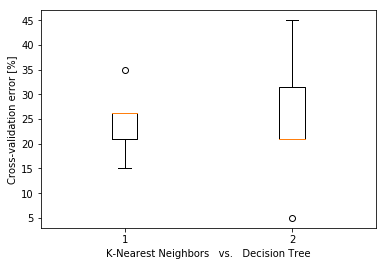

In [46]:
# The two best performing models are from dct
print('Outer error dct is' + str(error_dct))
print('Outer error of KNN is' + str(error_KNN))
print('Outer error of baseline_model is' + str(error_baseline))

figure()
boxplot([error_KNN, error_dct])
xlabel('K-Nearest Neighbors   vs.   Decision Tree')
ylabel('Cross-validation error [%]')


In [54]:
# The best performing classifiers are KNN with K = 2 and a dtc with tc=10

## Crossvalidation
# Create crossvalidation partition for evaluation
K = 10
CV = model_selection.KFold(n_splits=K,shuffle=True)
#CV = model_selection.StratifiedKFold(n_splits=K)

# Initialize variables
Error_base_line = np.empty((K,1))
Error_model_1 = np.empty((K,1))
Error_model_2 = np.empty((K,1))

n_tested=0

k=0
for train_index, test_index in CV.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K))
    
    # extract training and test set for current CV fold
    X_train = X[train_index,:]
    y_train = y[train_index]
    X_test = X[test_index,:]
    y_test = y[test_index]

    # Fit and evaluate KNN
    model1 = KNeighborsClassifier(n_neighbors=2, p=dist);
    model1 = model1.fit(X_train, y_train)
    y_model1 = model1.predict(X_test)
    Error_model_1[k] = 100*(y_model1!=y_test).sum().astype(float)/len(y_test)
    
    # Fit and evaluate Decision Tree classifier
    model2 = tree.DecisionTreeClassifier(criterion='gini', max_depth=10);
    model2 = model2.fit(X_train, y_train.ravel())
    y_model2 = model2.predict(X_test)
    Error_model_2[k] = 100*(y_model2!=y_test).sum().astype(float)/len(y_test)  
    
    # Fit and evaluate baseline model classifier
    y_baseline = Baseline_model(y_train, y_test);
    Error_base_line[k] = 100*(y_baseline!=y_test).sum().astype(float)/len(y_test)
  
    k+=1

# Comparison of Baseline model with model 1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_1)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and baseline model are not significantly different')        
else:
    print('Model 1 and baseline model are significantly different.')
print(zL)
print(zH)

# Comparison of Baseline model with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Baseline model and Model 2 are not significantly different')        
else:
    print('Baseline model and Model 2 are significantly different.')
print(zL)
print(zH)

# Comparison of model 1 with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_model_1-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and Model 2 are not significantly different')        
else:
    print('Model 1 and Model 2 are significantly different.')
print(zL)
print(zH)

CV-fold 1 of 10
CV-fold 2 of 10
CV-fold 3 of 10
CV-fold 4 of 10
CV-fold 5 of 10
CV-fold 6 of 10
CV-fold 7 of 10
CV-fold 8 of 10
CV-fold 9 of 10
CV-fold 10 of 10
Model 1 and baseline model are significantly different.
20.674506993717365
48.43660411739375
Baseline model and Model 2 are significantly different.
31.97642597819574
49.13468513291537
Model 1 and Model 2 are not significantly different
-1.86138429702791
13.861384297027907


# Gammel kode

In [25]:
# Initialize variables
Error_base_line = min(error_baseline)
Error_model_1 = min(error_dct) # Gives the best performing model
Error_model_2 = sorted(error_dct)[1] # Gives the second best performing model

# Comparison of Baseline model with model 1

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_1)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and baseline model are not significantly different')        
else:
    print('Model 1 and baseline model are significantly different.')
print(zL)
print(zH)

# Comparison of Baseline model with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_base_line-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2);
zH = zb + sig * stats.t.ppf(1-alpha/2);

if zL <= 0 and zH >= 0 :
    print('Model 2 and baseline model are not significantly different')        
else:
    print('Model 2 and baseline model are significantly different.')
print(zL)
print(zH)

# Comparison of model 1 with model 2

# Test if classifiers are significantly different using methods in section 9.3.3
# by computing credibility interval. Notice this can also be accomplished by computing the p-value using
# [tstatistic, pvalue] = stats.ttest_ind(Error_logreg,Error_dectree)
# and test if the p-value is less than alpha=0.05. 
z = (Error_model_1-Error_model_2)
zb = z.mean()
nu = K-1
sig =  (z-zb).std()  / np.sqrt(K-1)
alpha = 0.05

zL = zb + sig * stats.t.ppf(alpha/2, nu);
zH = zb + sig * stats.t.ppf(1-alpha/2, nu);

if zL <= 0 and zH >= 0 :
    print('Model 1 and Model 2 are not significantly different')        
else:
    print('Model 1 and Model 2 are significantly different.')
print(zL)
print(zH)

NameError: name 'K' is not defined

### Two level cross validation for KNN - Greta

In [25]:
## Crossvalidation for KNN
# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True)
#CV = model_selection.StratifiedKFold(n_splits=K)
index_min_lst = []
min_indices = []
error_outer = [] # List for the errors in outer CV fold

# Initialize variables
#Error_logreg = np.empty((K_outer,1))
#Error_KNN_inner = np.empty((K_inner,3))
#Error_NaïveB = np.empty((K_outer,1))
#n_tested=0

K_KNN = [1, 2, 3] # Change here for different nearest neighbour crossvalidation

k=0
classifier_lst = []

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
        for count, value in enumerate(K_KNN):
            dist=1
    
            knclassifier = KNeighborsClassifier(n_neighbors=value, p=dist);
            knclassifier.fit(X_train_inner, y_train_inner);
            classifier_lst.append(knclassifier)
            
            y_KNN = knclassifier.predict(X_test_inner);
            errorKNN_inner = 100*(y_KNN!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            index_min_lst.append(errorKNN_inner) #Append the error values to a list
            
        # Find the KNN value with least error value
        index_min = np.argmin(index_min_lst) #Find the index of the minimum error value
        min_indices.append(index_min) 
        
        index_min_lst = [] # Clear for next CV fold
        
        kk += 1

        counts = np.bincount(min_indices) # Count which index appears the maximum number of times = i.e. the must be the least error value
        top_count = np.argmax(counts)
        # Only use the count from the last iteration! 
        optimal_K = K_KNN[top_count]
        
    print('The index of optimal KNN value is: ' + str(top_count))

    print('The optimal KNN value across inner CV folds is: ' + str(optimal_K))
    
    knclassifierOuter = KNeighborsClassifier(n_neighbors=optimal_K, p=dist); #Uses optimal_K, which was found in the inner CV loop
    knclassifierOuter.fit(X_train_outer, y_train_outer);
            
    y_KNN_outer = knclassifier.predict(X_test_outer);
    errorKNN_outer = 100*(y_KNN_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer.append(errorKNN_outer)
    print('Errors for each outer CV fold: ' + str(error_outer))
    
        
    

CV-fold 1 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
The index of optimal KNN value is: 1
The optimal KNN value across inner CV folds is: 2
Errors for each outer CV fold: [10.0]
CV-fold 2 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
The index of optimal KNN value is: 1
The optimal KNN value across inner CV folds is: 2
Errors for each outer CV fold: [10.0, 15.0]
CV-fold 3 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
The index of optimal KNN value is: 1
The optimal KNN value across inner CV folds is: 2
Errors for each outer CV fold: [10.0, 15.0, 36.8421052631579]
CV-fold 4 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
The index of optimal KNN value is: 1
The optimal KNN value across inner CV folds is: 2
Errors for each outer CV fol

In [24]:
## Crossvalidation for KNN
# Create crossvalidation partition for evaluation
K_outer = 5
K_inner = 5
CV_outer = model_selection.KFold(n_splits=K_outer,shuffle=True)
#CV = model_selection.StratifiedKFold(n_splits=K)
errorKNN_inner_GT=[]
errorKNN_outer_GT = []
index_min_lst = []
min_indices = []
error_outer = []

# Initialize variables
#Error_logreg = np.empty((K_outer,1))
#Error_KNN_inner = np.empty((K_inner,3))
#Error_NaïveB = np.empty((K_outer,1))
#n_tested=0

K_KNN = range(1,41)

k=0
classifier_lst = []

for train_outer_index, test_outer_index in CV_outer.split(X_classification,y_classification):
    print('CV-fold {0} of {1}'.format(k+1,K_outer))
    k += 1
    
    # extract training and test set for current CV fold
    X_train_outer = X_classification[train_outer_index,:]
    y_train_outer = y_classification[train_outer_index]
    X_test_outer = X_classification[test_outer_index,:]
    y_test_outer = y_classification[test_outer_index]
    
    CV_inner = model_selection.KFold(n_splits=K_inner,shuffle=True)
    
    kk=0
    for train_inner_index, test_inner_index in CV_inner.split(X_train_outer,y_train_outer):
        print('Inner CV-fold {0} of {1}'.format(kk+1,K_inner))

        # extract training and test set for current CV fold
        X_train_inner = X_train_outer[train_inner_index,:]
        y_train_inner = y_train_outer[train_inner_index]
        X_test_inner = X_train_outer[test_inner_index,:]
        y_test_inner = y_train_outer[test_inner_index]
        
#         print(len(X_train_inner))
#         print(len(y_train_inner))
        
        for count, value in enumerate(K_KNN):
            dist=1
    
            knclassifier = KNeighborsClassifier(n_neighbors=value, p=dist);
            knclassifier.fit(X_train_inner, y_train_inner);
            classifier_lst.append(knclassifier)
            
            y_KNN = knclassifier.predict(X_test_inner);
            errorKNN_inner_GT = 100*(y_KNN!=y_test_inner).sum().astype(float)/len(y_test_inner)  
            index_min_lst.append(errorKNN_inner_GT) #Append the error values to a list
            
        # Find the KNN value with least error value
        index_min = np.argmin(index_min_lst) #Find the index of the minimum error value
        min_indices.append(index_min) 
        
        index_min_lst = [] # Clear for next CV fold
        
        kk += 1

    print(min_indices)
    counts = np.bincount(min_indices) # Count which index appears the maximum number of times = i.e. the must be the least error value
    top_count = np.argmax(counts)
    print('The index of optimal KNN value is: ' + str(top_count))
    
    # Only use the count from the last iteration! 
    optimal_K = K_KNN[top_count]
    print('The optimal KNN value across inner CV folds is: ' + str(optimal_K))
    
    knclassifierOuter = KNeighborsClassifier(n_neighbors=1, p=dist);
    knclassifierOuter.fit(X_train_outer, y_train_outer);
            
    y_KNN_outer = knclassifier.predict(X_test_outer);
    errorKNN_outer_GT = 100*(y_KNN_outer!=y_test_outer).sum().astype(float)/len(y_test_outer)
    error_outer.append(errorKNN_outer_GT)
    print(error_outer)
    
        
    

CV-fold 1 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
[1, 2, 0, 13, 19]
The index of optimal KNN value is: 0
The optimal KNN value across inner CV folds is: 1
[15.0]
CV-fold 2 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
[1, 2, 0, 13, 19, 7, 2, 3, 1, 1]
The index of optimal KNN value is: 1
The optimal KNN value across inner CV folds is: 2
[15.0, 35.0]
CV-fold 3 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
[1, 2, 0, 13, 19, 7, 2, 3, 1, 1, 0, 33, 18, 3, 4]
The index of optimal KNN value is: 1
The optimal KNN value across inner CV folds is: 2
[15.0, 35.0, 10.526315789473685]
CV-fold 4 of 5
Inner CV-fold 1 of 5
Inner CV-fold 2 of 5
Inner CV-fold 3 of 5
Inner CV-fold 4 of 5
Inner CV-fold 5 of 5
[1, 2, 0, 13, 19, 7, 2, 3, 1, 1, 0, 33, 18, 3, 4, 0, 29, 24, 8, 13]
The index of optimal KNN value is: 0
